# 7.5.1 Medium: Apply the ARIMA(p,d,q) model on the datasets from chapters 4, 5 or 6  

In chapters 4, 5 and 6, non-stationary time series were introduced to understand how to apply the MA(q) model, AR(p) model and ARMA(p,q) model. In each chapter, we transformed the series to make it stationary, fit the mode, made forecasts, and had to reverse the transformation on the forecasts to bring them back to the original scale of the data.  

Now that we know how to account for non-stationary time series, revisit each dataset and
apply the ARIMA(p,d,q) model. For each dataset:  

Apply the general modeling procedure.  
* Is an ARIMA(0,1,2) model suitable for the dataset in chapter 4?
* Is an ARIMA(3,1,0) model suitable for the dataset in chapter 5?
* Is an ARIMA(2,1,2) model suitable for the dataset in chapter 6?

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# omd
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '/home/oliver/Documents/Code/myrepos/TimeSeriesForecastingInPython/MyWork/../../My-Code/timetools.py'>

<AxesSubplot:>

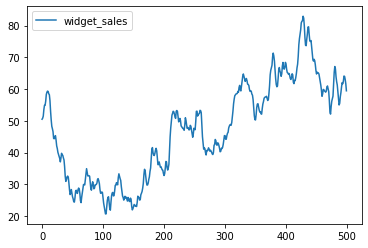

In [2]:
df = pd.read_csv('./data/widget_sales.csv')
df.plot()

Test Statistic                  -1.512166
p-value                          0.527485
#Lags Used                       3.000000
Number of Observations Used    496.000000
Critical Value (1%)             -3.443603
Critical Value (5%)             -2.867385
Critical Value (10%)            -2.569883
dtype: float64

The time series is not stationary.


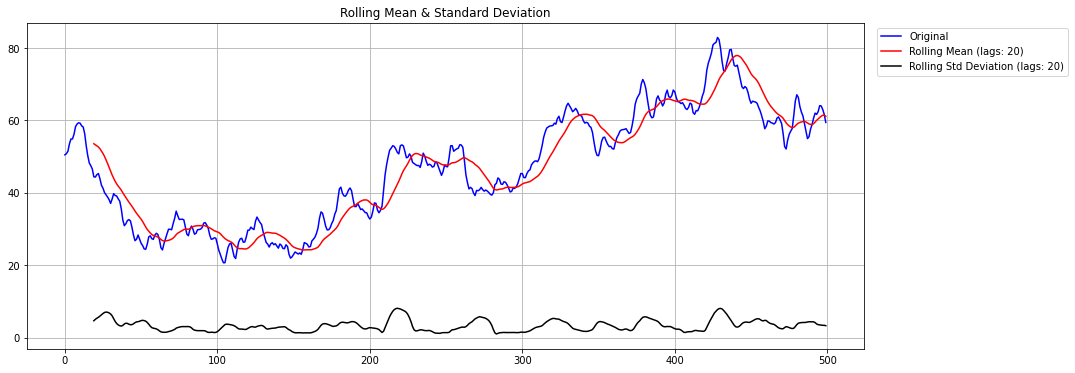

In [3]:
tt.adf(df)
tt.plot_for_stationary(df)

Test Statistic                -1.057666e+01
p-value                        7.076923e-19
#Lags Used                     2.000000e+00
Number of Observations Used    4.960000e+02
Critical Value (1%)           -3.443603e+00
Critical Value (5%)           -2.867385e+00
Critical Value (10%)          -2.569883e+00
dtype: float64

The time series is stationary.


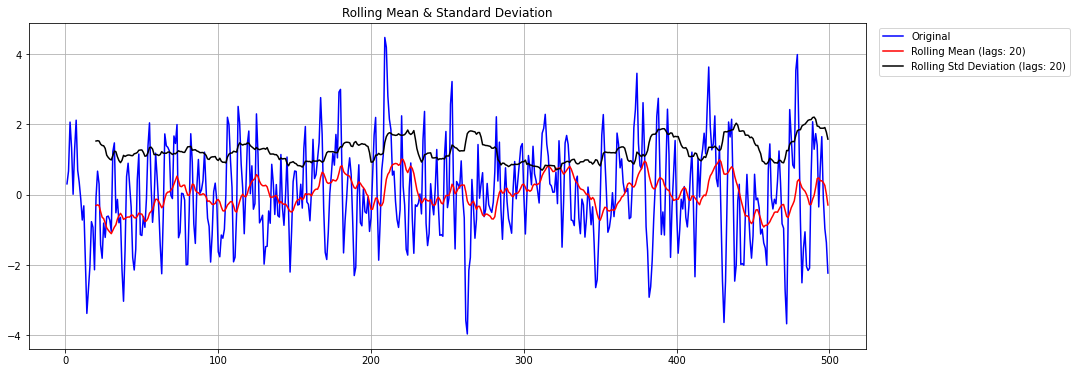

In [4]:
tt.adf(df.diff(1)[1:])
tt.plot_for_stationary(df.diff(1)[1:])


In [5]:
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [10]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1
order_list = list(product(ps, qs))

train, test = df['widget_sales'][:-50], df[-50:]     # make test set a dataframe so that it's easier to append forecast to actuals in test

result_df = tt.optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.431529
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643259


In [28]:
model = SARIMAX(train, order=(3,d,3), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.716
Date:                Sun, 02 Jan 2022   AIC                           1251.432
Time:                        20:07:00   BIC                           1280.181
Sample:                             0   HQIC                          1262.764
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3626      0.064     21.175      0.000       1.236       1.489
ar.L2         -1.3524      0.065    -20.827      0.000      -1.480      -1.225
ar.L3          0.3506      0.064      5.453      0.0

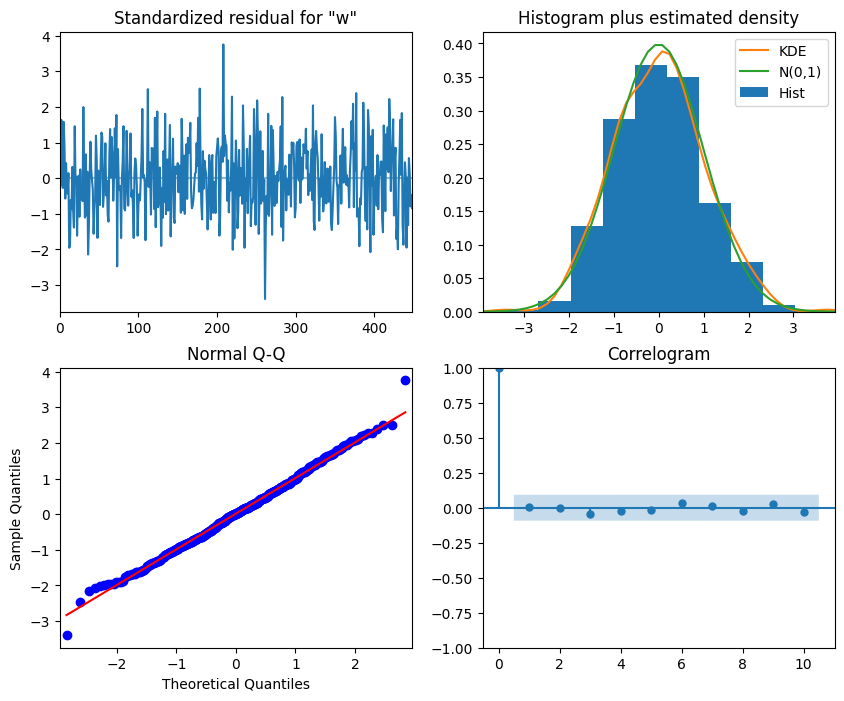

In [29]:
model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.89 > 0.05
The residuals are not correlated.  Like white noise!


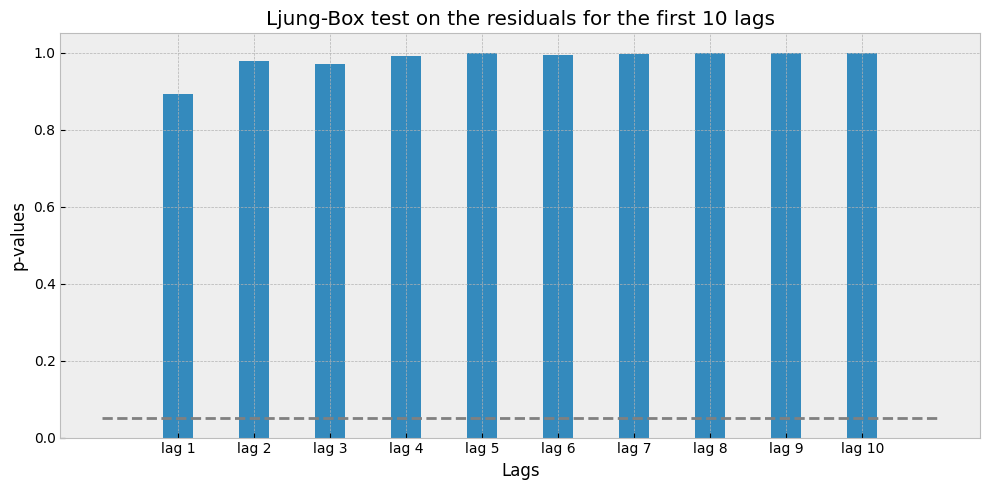

In [30]:
tt.ljungbox(residuals, lags=10)

In [31]:
ARIMA_pred = model_fit.get_prediction(450, 500).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test.head()

,widget_sales,ARIMA_pred
450,64.736005,64.811513
451,65.316972,64.718193
452,65.172070,65.031750
453,65.075506,65.201488
454,64.703173,64.976012


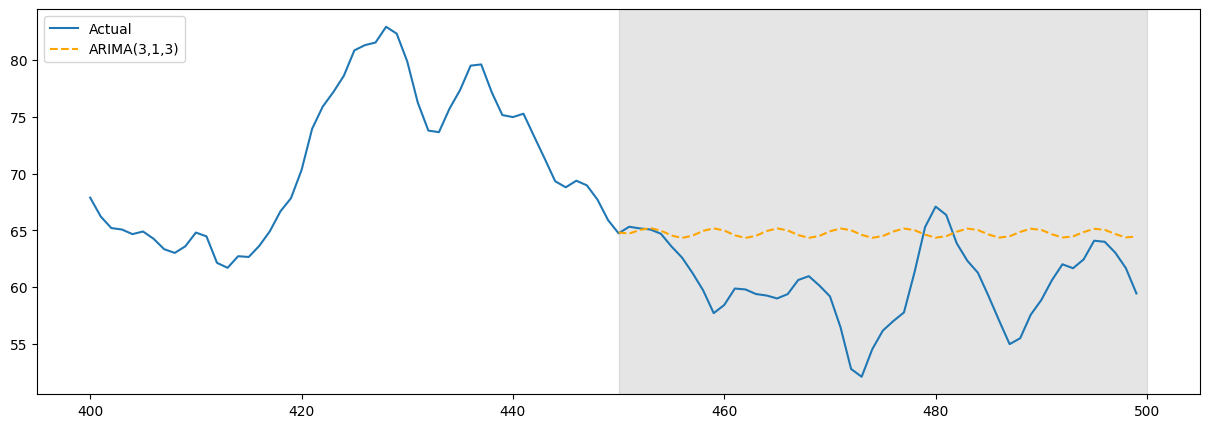

In [32]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df[400:], label='Actual')
ax.axvspan(xmin=450, xmax=500, color='#808080', alpha=0.2)
ax.plot(test['ARIMA_pred'], color='orange', ls='--', label='ARIMA(3,1,3)')
plt.legend()
plt.show()

In [33]:
mse_arima = mean_squared_error(test['widget_sales'], test['ARIMA_pred'])
mse_arima

30.62391770297735